# Cross Entropy Benchmarking (XEB)

To demonstrate the cross entropy benchmarking routine, consider a noise model with two independent
depolarising channels, one which only effects single qubit gates and a second that only effects
two qubit gates.

In [1]:
from __future__ import annotations
import cirq
import numpy as np


class IndependentDepolariseNoiseModel(cirq.NoiseModel):
    """Applies single and two qubit depolarising channels independently"""

    def __init__(self, single_qubit_error: float, two_qubit_error: float) -> None:
        """Args:
        single_qubit_error: Single qubit pauli error
        two_qubit_error: Two qubit pauli error
        """
        super().__init__()
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error

        self.single_qubit_depolarise = cirq.DepolarizingChannel(p=single_qubit_error, n_qubits=1)
        self.two_qubit_depolarise = cirq.DepolarizingChannel(p=two_qubit_error, n_qubits=2)

    def noisy_operation(self, operation: cirq.Operation) -> list[cirq.OP_TREE]:
        """Produces a list of operations by applying each noise model
        to the provided operation depending on the number of qubits it acts on.
        """
        if len(operation.qubits) == 1:
            return [operation, self.single_qubit_depolarise(*operation.qubits)]

        if len(operation.qubits) == 2:
            return [operation, self.two_qubit_depolarise(*operation.qubits)]

        return [operation]


noise = IndependentDepolariseNoiseModel(single_qubit_error=0.005, two_qubit_error=0.02)
simulator = cirq.DensityMatrixSimulator(
    noise=noise,
)

The XEB experiment allows us to estimate the fidelity of a "layer" composed of pair of single 
qubit gates followed by a two qubit gate. If each single qubit gate is effected by a pauli error
channel with rate $p_1$ and each two qubit gate is effected by a two qubit 
depolarising channel with pauli $p_2$ the overall layer depolarising error is
$$e_L = \frac{16}{15}\left( 1 - \left(1- p_1\right)^2 \left(1-p_2\right) \right)$$

In [2]:
from supermarq.qcvv import XEB


experiment = XEB()
experiment.prepare_experiment(num_circuits=25, cycle_depths=[1, 10, 50, 100])
experiment.run_with_simulator(simulator=simulator)

Building circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Layer depolarising error:  0.031760533333333285
Estimated layer depolarising error:  0.03180672996678657


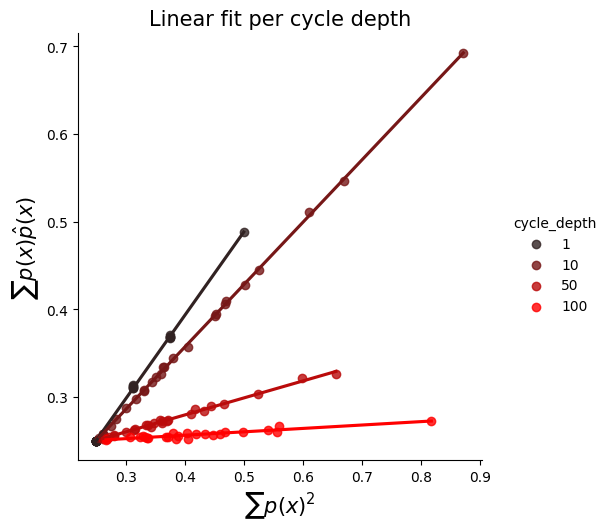

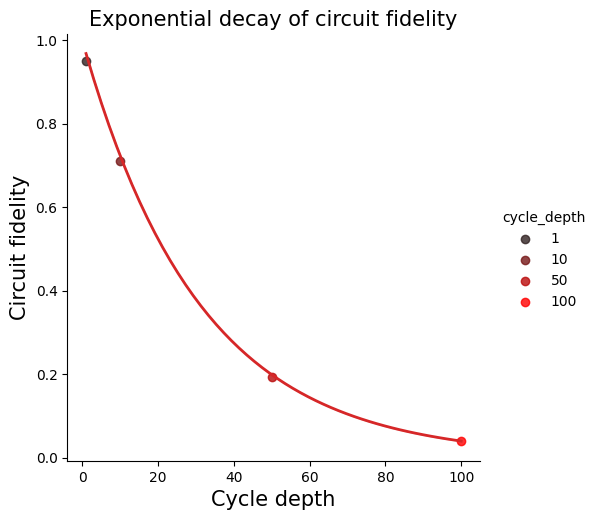

In [3]:
if experiment.collect_data():
    experiment.analyze_results(plot_results=True)
layer_depolarising_error = (
    16 / 15 * (1 - (1 - noise.single_qubit_error) ** 2 * (1 - noise.two_qubit_error))
)
layer_depolarising_error_estimate = 1 - experiment.results.layer_fidelity_estimate
print("Layer depolarising error: ", layer_depolarising_error)
print("Estimated layer depolarising error: ", layer_depolarising_error_estimate)

Now lets repeat a similar experiment, still using two qubits but this time without entangling 
gates between them. In this case our noise model reduces to a pair of independent single 
qubit depolarising channels with pauli rates $p_1$, or equivalently depolarising rates of 
$e_{1q} = \tfrac34 p_1$. 

Each layer is made up of two single qubit gates (one on each qubit) so we obtain a layer fidelity of
$$f_L = (1- e_{1q})^2$$

Thus we can estimate the single qubit pauli error as 
$$p_1 = \frac{4}{3} \left(1-\sqrt{f_L}\right)$$

In [4]:
single_qubit_experiment = XEB(two_qubit_gate=None)
single_qubit_experiment.prepare_experiment(25, cycle_depths=[10, 50, 100, 200])
single_qubit_experiment.run_with_simulator(simulator=simulator)

Building circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating circuits:   0%|          | 0/100 [00:00<?, ?it/s]

Single qubit pauli error:  0.005
Estimated single qubit pauli error:  0.005067386913476153


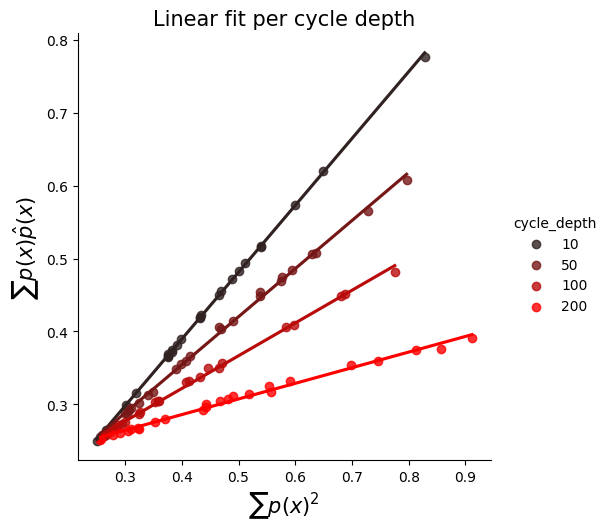

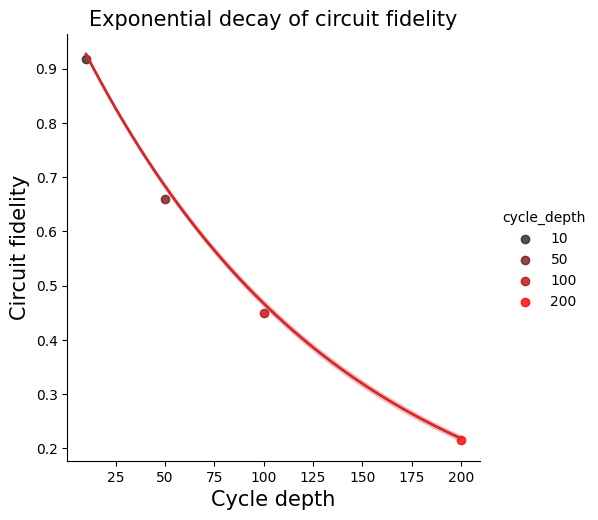

In [5]:
if single_qubit_experiment.collect_data():
    single_qubit_experiment.analyze_results(plot_results=True)
single_qubit_pauli_error_estimate = (
    4 / 3 * (1 - np.sqrt(single_qubit_experiment.results.layer_fidelity_estimate))
)

print("Single qubit pauli error: ", noise.single_qubit_error)
print("Estimated single qubit pauli error: ", single_qubit_pauli_error_estimate)

We can now rearrange the equation above to estimate the two qubit depolarising error
$$ e_{2q}  = \frac{16}{15} \left(1 - \frac{1-\tfrac{15}{16}e_L}{\left(1 - \tfrac43 e_{1q}\right)^2} \right)$$

In [6]:
two_qubit_depolarising_error = 16 / 15 * noise.two_qubit_error
two_qubit_depolarising_error_estimate = (16 / 15) * (
    1
    - (
        (1 - 15 / 16 * layer_depolarising_error_estimate)
        / (1 - single_qubit_pauli_error_estimate) ** 2
    )
)
print("Two qubit depolarising error: ", two_qubit_depolarising_error)
print("Estimated two qubit depolarising error: ", two_qubit_depolarising_error_estimate)

Two qubit depolarising error:  0.021333333333333333
Estimated two qubit depolarising error:  0.02123839582540962
